In [94]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import get_window
from matplotlib import rcParams

# 设置字体
rcParams['font.sans-serif'] = ['SimHei']  # 设置为黑体（SimHei），也可以选择其他字体，如 Microsoft YaHei
rcParams['axes.unicode_minus'] = False   # 解决负号显示问题

# 读取.mat文件
# 注意替换为你自己的文件路径
data1 = loadmat("mic_data.mat")  
# 提取数据
s0 = data1['m0_part']     # reference mic Mr
s1 = data1['m1_part']     # common mic Mc
s2 = data1['m2_part']

p0 = 2 * 10 ** (-5)

N0 = len(s0)
N1 = len(s1)

t0 = np.arange(N0)
t1 = np.arange(N1)

fs = 40000

segConst = 4000
overlapConst = segConst // 2
nfftConst = segConst
ordersConst = 8001



In [95]:
def plotASignal(x, y):
    plt.figure(figsize=(12, 4))
    plt.plot(x, y)

    plt.show()

In [96]:
def plotTwoSignal(x, y1, y2, title1, title2):
    plt.figure(figsize=(15, 4))
    plt.plot(x, y1, label = title1)
    plt.plot(x, y2, label = title2, linestyle = '--')

    plt.legend()

    plt.show()

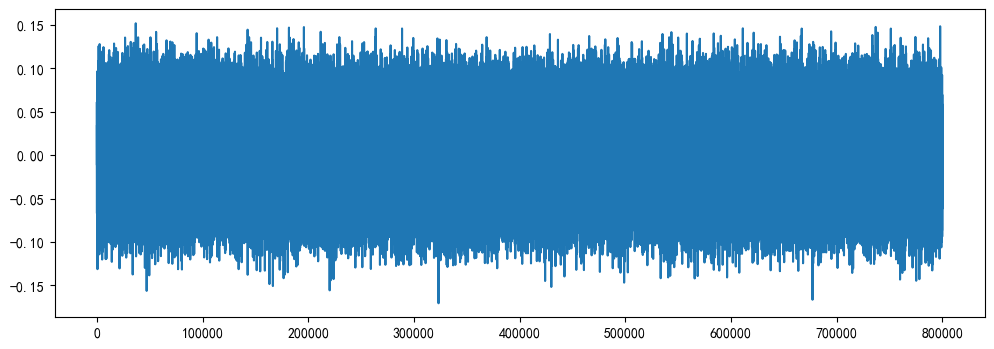

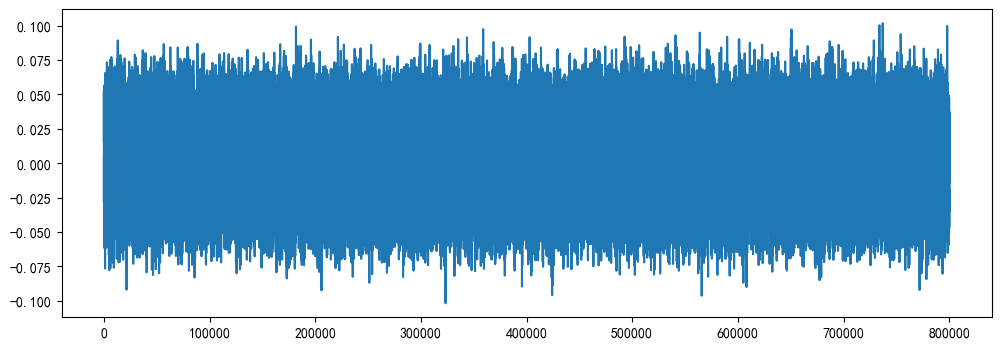

(800001, 800001)

In [97]:
plotASignal(t0, s0)
plotASignal(t1, s1)
N0, N1

In [98]:
from scipy.signal import welch

# 使用Welch方法计算功率谱密度（PSD）
s0 = s0.flatten()
s0 /= p0
f1, Pxx1 = welch(s0, fs, window='blackman', nperseg=fs, noverlap=fs // 2, nfft=fs, 
                   detrend='constant', return_onesided=True, scaling='density', axis=-1, 
                   average='mean')
s1 = s1.flatten()
s1 /= p0
f2, Pxx2 = welch(s1, fs, window='blackman', nperseg=fs, noverlap=fs // 2, nfft=fs, 
                   detrend='constant', return_onesided=True, scaling='density', axis=-1, 
                   average='mean')
s2 = s2.flatten()
s2 /= p0

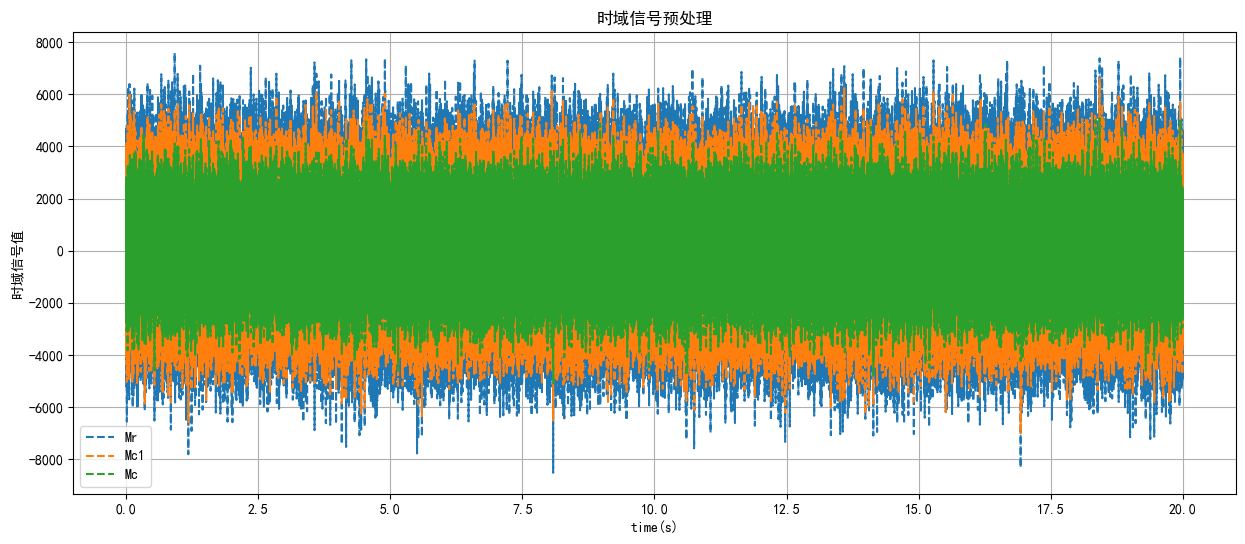

In [99]:
# 绘制功率谱密度图
plt.figure(figsize=(15, 6))
plt.plot(t0 / fs, s0, linestyle = '--', label = 'Mr')
plt.plot(t0 / fs, s2, linestyle = '--', label = 'Mc1')
plt.plot(t0 / fs, s1, linestyle = '--', label = 'Mc')
plt.title('时域信号预处理')
plt.xlabel('time(s)')
plt.ylabel('时域信号值')
plt.grid(True)
plt.legend()
plt.show()

In [100]:
# 筛选频率范围20Hz到20kHz
freq_range1 = (f1 >= 20) & (f1 <= 20000)
f1_period1 = f1[freq_range1]
Pxx1_period1 = Pxx1[freq_range1]

freq_range2 = (f2 >= 20) & (f2 <= 20000)
f2_period1 = f2[freq_range2]
Pxx2_period1 = Pxx2[freq_range2]

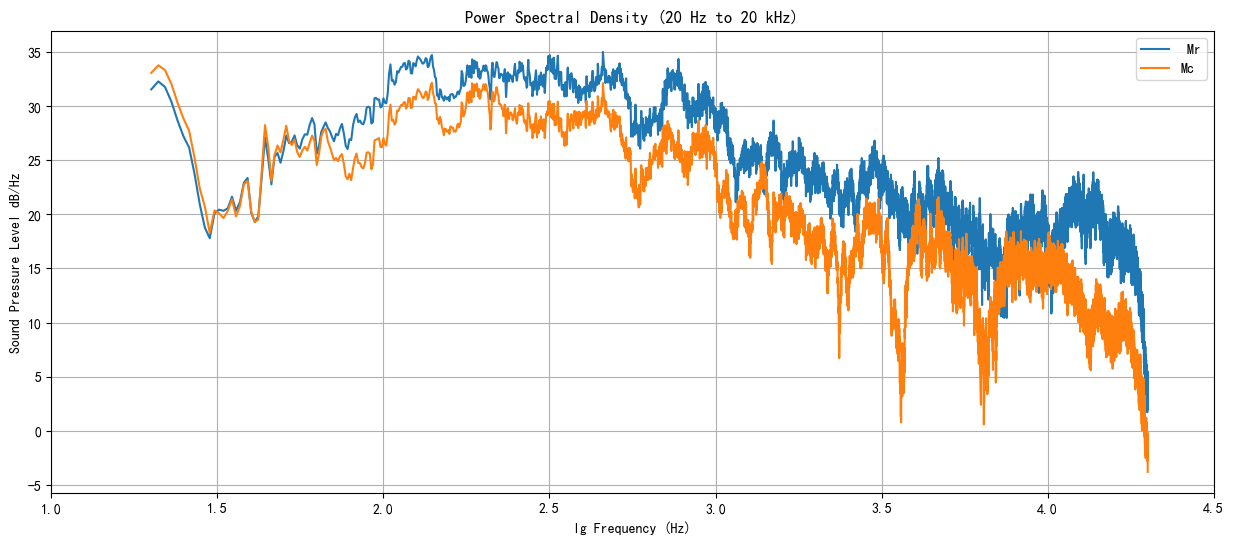

In [101]:
# 绘制功率谱密度图
plt.figure(figsize=(15, 6))
plt.plot(np.log10(f1_period1), 10 * np.log10(Pxx1_period1), label = ' Mr')
plt.plot(np.log10(f2_period1), 10 * np.log10(Pxx2_period1), label = 'Mc')
plt.title('Power Spectral Density (20 Hz to 20 kHz)')
plt.xlabel('lg Frequency (Hz)')
plt.ylabel('Sound Pressure Level dB/Hz')
plt.xlim(1, 4.5)
plt.grid(True)
plt.legend()
plt.show()

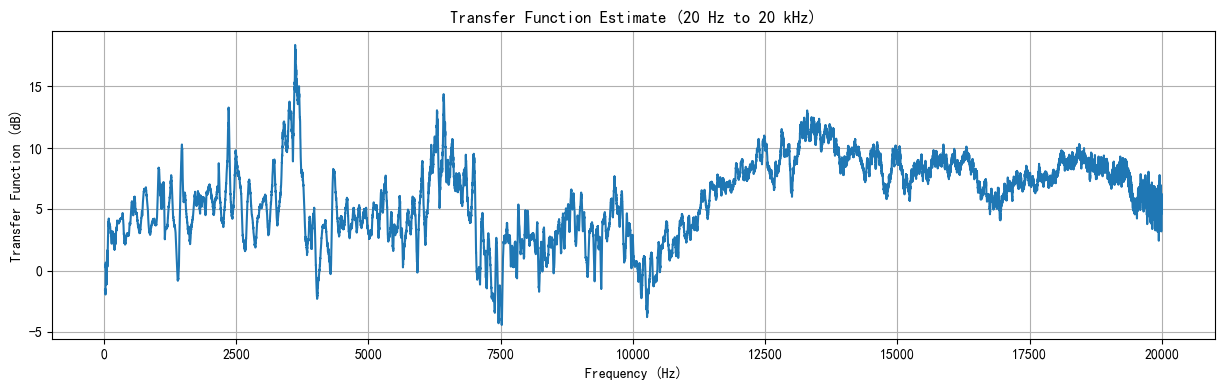

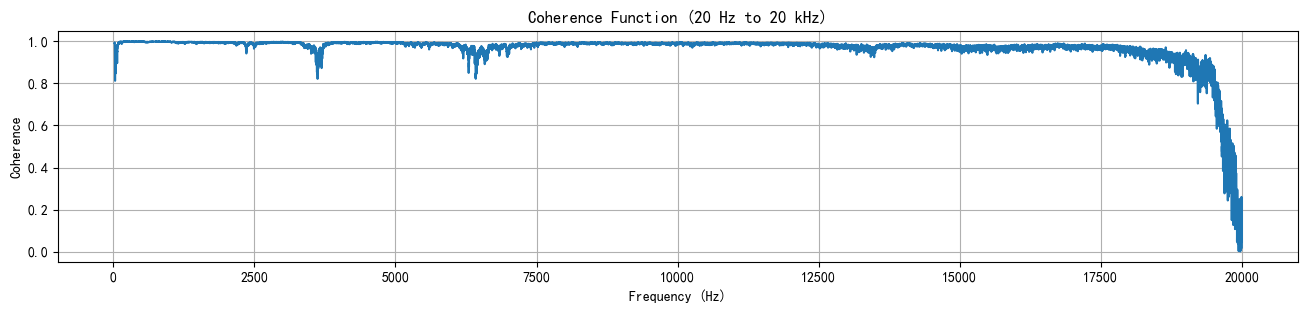

In [102]:
from scipy.signal import coherence
# 计算传递率估计
Txy = np.sqrt(Pxx1 / Pxx2)
Txy_period1 = Txy[freq_range2]

# 计算相干系数和频率数组
f, Cxy = coherence(s0, s1, fs, nperseg=fs)

# 筛选频率范围20Hz到20kHz
freq_range = (f >= 20) & (f <= 20000)
f = f[freq_range]
# Txy = Txy[freq_range]
Cxy = Cxy[freq_range]

# 绘制传递率估计图
plt.figure(figsize=(15, 4))
plt.plot(f1_period1, 20 * np.log10(Txy_period1))
plt.title('Transfer Function Estimate (20 Hz to 20 kHz)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Transfer Function (dB)')
plt.grid(True)
plt.show()

# 绘制相干系数图
plt.figure(figsize=(16, 3))
plt.plot(f, Cxy)
plt.title('Coherence Function (20 Hz to 20 kHz)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Coherence')
plt.grid(True)
plt.show()

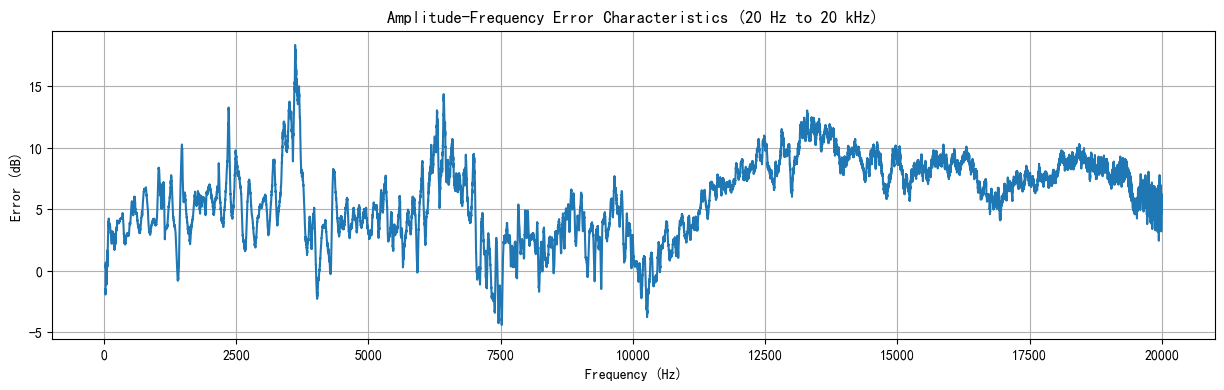

频段误差分布均值：5.927373837603049 dB
频段误差分布标准差：3.175025821855957 dB


In [103]:
# 计算幅频误差特性（以dB为单位）
error_dB = 20 * np.log10(np.sqrt(Pxx1) / np.sqrt(Pxx2))
error_dB = error_dB[freq_range1]

# 计算频段误差分布相关统计量（如均值、标准差等，这里仅以均值为例）
error_mean = np.mean(error_dB)
error_std = np.std(error_dB)

# 绘制幅频误差特性图
plt.figure(figsize=(15, 4))
plt.plot(f1_period1, error_dB)
plt.title('Amplitude-Frequency Error Characteristics (20 Hz to 20 kHz)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Error (dB)')
plt.grid(True)
plt.show()

print(f"频段误差分布均值：{error_mean} dB")
print(f"频段误差分布标准差：{error_std} dB")

In [104]:
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import firwin, lfilter

In [105]:
# 先对频谱求log
S0_log = 10 * np.log10(Pxx1)
S1_log = 10 * np.log10(Pxx2)

In [106]:
# 两个频率
frequencies = f1
freq_mask1 = (frequencies >= 20) & (frequencies <= 20000)
freq_mask2 = (frequencies >= 200) & (frequencies <= 2000)

frequencies1 = frequencies[freq_mask1]
frequencies2 = frequencies[freq_mask2]

In [107]:
# 全音频段与语言敏感频段
S0_period1 = S0_log[freq_mask1]
S0_period2 = S0_log[freq_mask2]
S1_period1 = S1_log[freq_mask1]
S1_period2 = S1_log[freq_mask2]

In [108]:
# 求平滑Txy
f1, Pxx1 = welch(s0, fs, window='hamming', nperseg=segConst, noverlap=overlapConst, nfft=nfftConst, 
                   detrend='constant', return_onesided=True, scaling='density', axis=-1, 
                   average='mean')
f2, Pxx2 = welch(s1, fs, window='hamming', nperseg=segConst, noverlap=overlapConst, nfft=nfftConst, 
                   detrend='constant', return_onesided=True, scaling='density', axis=-1, 
                   average='mean')
Txy_smooth = np.sqrt(Pxx1 / Pxx2)

In [109]:
print(len(Txy_smooth))

2001


In [110]:
from scipy.signal import firwin2
nyquist_freq = 0.5  # Nyquist 频率，采样频率的一半

N = len(Txy_smooth)

freq = np.linspace(0, nyquist_freq, N, endpoint=True)

gain = Txy_smooth

# freq = freq[::10]
# gain = gain[::10]

print(len(freq), freq * 20000)
print(len(gain), gain)

# 归一化频率
freq_normalized = freq / (nyquist_freq)

numtaps = ordersConst  # 根据需要调整

# 设计 FIR 滤波器
taps = firwin2(numtaps, freq_normalized, gain, window='blackman')


2001 [0.000e+00 5.000e+00 1.000e+01 ... 9.990e+03 9.995e+03 1.000e+04]
2001 [0.82449536 0.82242981 0.82421738 ... 1.89260944 1.81006221 1.82359785]


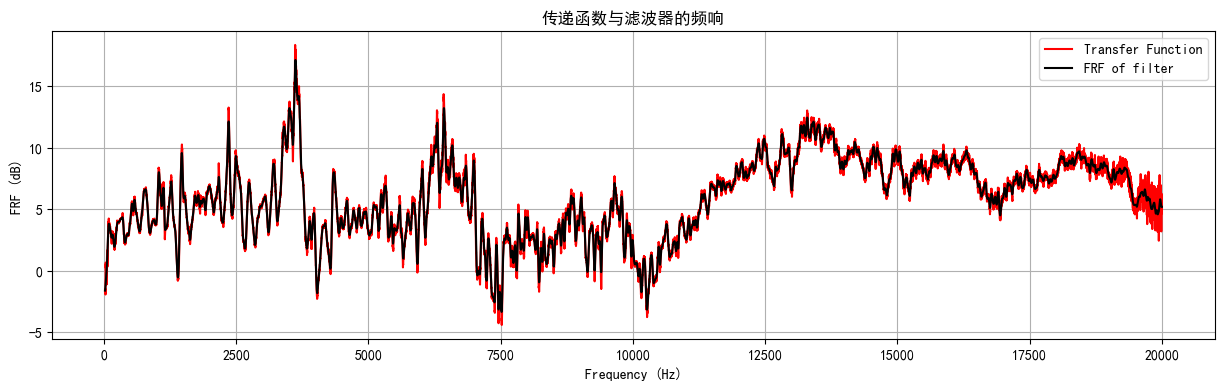

In [111]:
from scipy.signal import freqz
w, h = freqz(taps, [1], f1_period1 / (fs // 2) * np.pi)

plt.figure(figsize=(15, 4))
plt.plot(f1_period1, 20 * np.log10(Txy_period1), label = 'Transfer Function', color = 'red')
plt.plot(f1_period1, 20 * np.log10(abs(h)), label = 'FRF of filter', color = 'black')
plt.title('传递函数与滤波器的频响')
plt.xlabel('Frequency (Hz)')
plt.ylabel('FRF (dB)')
plt.legend()
plt.grid(True)
plt.show()

In [112]:
s1_filtered = lfilter(taps, 1.0, s1)
f_filterd, S1_filterd = welch(s1_filtered, fs, window='hamming', nperseg=fs, noverlap=fs // 2, nfft=fs, 
                   detrend='constant', return_onesided=True, scaling='density', axis=-1, 
                   average='mean')
S1_filterd_log = 10 * np.log10(S1_filterd)

In [113]:
S1_filterd_period1 = S1_filterd_log[freq_mask1]
S1_filterd_period2 = S1_filterd_log[freq_mask2]

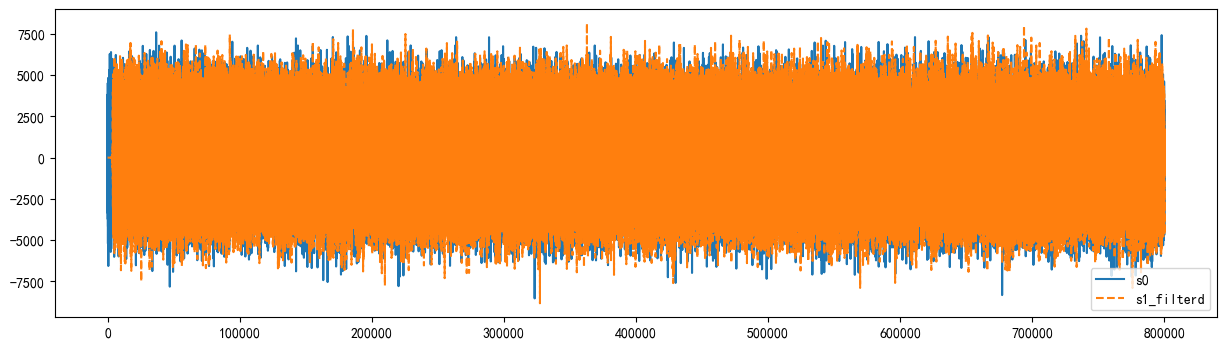

In [114]:
plotTwoSignal(t0, s0, s1_filtered, 's0', 's1_filterd')

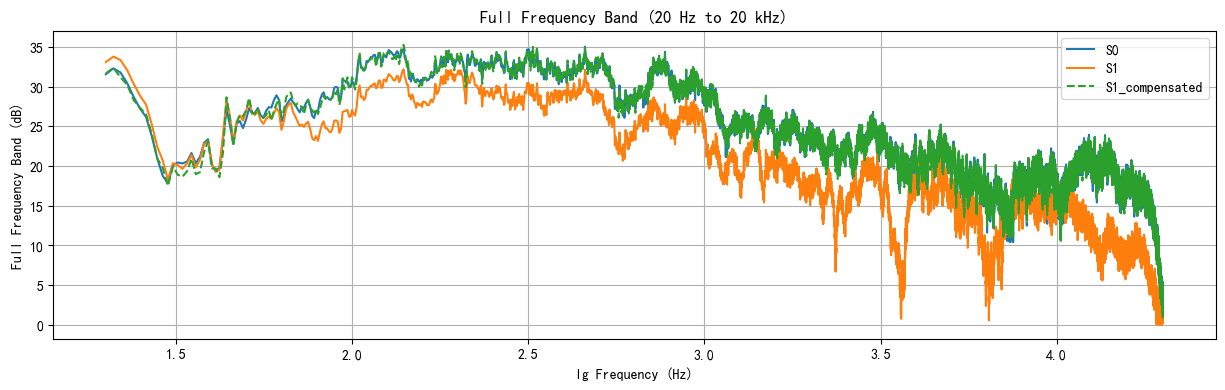

In [115]:
# 对比s0的频域 和 修正过后的s1 的频域
plt.figure(figsize=(15, 4))
plt.plot(np.log10(frequencies1), np.abs(S0_period1), label = 'S0')
plt.plot(np.log10(frequencies1), np.abs(S1_period1), linestyle = '-', label = 'S1')
plt.plot(np.log10(frequencies1), np.abs(S1_filterd_period1), linestyle = '--', label = 'S1_compensated')
plt.legend()
plt.title('Full Frequency Band (20 Hz to 20 kHz)')
plt.xlabel('lg Frequency (Hz)')
plt.ylabel('Full Frequency Band (dB)')
plt.grid(True)
plt.show()

In [116]:
# 计算误差

# 全音频段
S0_mag = S0_period1
S1_mag = S1_period1
S1_filterd_mag = S1_filterd_period1

error_before = np.mean(np.abs(S0_mag - S1_mag))
error_after = np.mean(np.abs(S0_mag - S1_filterd_mag))

# 打印误差
print("全音频段补偿前误差:", error_before, 'dB')
print("全音频段补偿后误差:", error_after, 'dB')

# 语言敏感频段

S0_mag = S0_period2
S1_mag = S1_period2
S1_filterd_mag = S1_filterd_period2

error_before = np.mean(np.abs(S0_mag - S1_mag))
error_after = np.mean(np.abs(S0_mag - S1_filterd_mag))

print("语言敏感频段补偿前误差 (200Hz - 2000Hz):", error_before, 'dB')
print("语言敏感频段补偿后误差 (200Hz - 2000Hz):", error_after, 'dB')

# 找到 1 kHz 对应的频率索引
target_freq = 1000  # 1 kHz
target_index = np.argmin(np.abs(frequencies - target_freq))

# 计算 1 kHz 处的幅度和相位误差
error_before_1k = S0_log[target_index] - S1_log[target_index]
error_after_1k = S0_log[target_index] - S1_filterd_log[target_index]

# 打印误差
print("1kHz 处补偿前误差:", error_before_1k, 'dB')
print("1kHz 处补偿后误差:", error_after_1k, 'dB')

全音频段补偿前误差: 6.022592919599243 dB
全音频段补偿后误差: 0.3272039494876155 dB
语言敏感频段补偿前误差 (200Hz - 2000Hz): 4.692220311116655 dB
语言敏感频段补偿后误差 (200Hz - 2000Hz): 0.2945442402520788 dB
1kHz 处补偿前误差: 4.118833276310706 dB
1kHz 处补偿后误差: -0.04418311658370655 dB


In [117]:
# 泛化
f1, Pxx1 = welch(s0, fs, window='blackman', nperseg=fs, noverlap=fs // 2, nfft=fs, 
                   detrend='constant', return_onesided=True, scaling='density', axis=-1, 
                   average='mean')
f2, Pxx2 = welch(s2, fs, window='blackman', nperseg=fs, noverlap=fs // 2, nfft=fs, 
                   detrend='constant', return_onesided=True, scaling='density', axis=-1, 
                   average='mean')
f = f1

In [118]:
S2_log = 10 * np.log10(Pxx2)

In [119]:
freq_range1 = (f >= 20) & (f <= 20000)
freq_range2 = (f >= 200) & (f <= 2000)
f_period1 = f[freq_range1]
f_period2 = f[freq_range2]
Pxx1_period1 = Pxx1[freq_range1]
Pxx2_period1 = Pxx2[freq_range1]
Pxx1_period2 = Pxx1[freq_range2]
Pxx2_period2 = Pxx2[freq_range2]

S0_period1 = 10 * np.log10(Pxx1_period1)
S0_period2 = 10 * np.log10(Pxx1_period2)
S1_period1 = 10 * np.log10(Pxx2_period1)
S1_period2 = 10 * np.log10(Pxx2_period2)

In [120]:
# 求平滑Txy
f1, Pxx1 = welch(s0, fs, window='hamming', nperseg=segConst, noverlap=overlapConst, nfft=nfftConst, 
                   detrend='constant', return_onesided=True, scaling='density', axis=-1, 
                   average='mean')
f2, Pxx2 = welch(s2, fs, window='hamming', nperseg=segConst, noverlap=overlapConst, nfft=nfftConst, 
                   detrend='constant', return_onesided=True, scaling='density', axis=-1, 
                   average='mean')
Txy_smooth = np.sqrt(Pxx1 / Pxx2)

In [121]:
from scipy.signal import firwin2
nyquist_freq = 0.5  # Nyquist 频率，采样频率的一半

N = len(Txy_smooth)

freq = np.linspace(0, nyquist_freq, N, endpoint=True)

gain = Txy_smooth

# freq = freq[::10]
# gain = gain[::10]

print(len(freq), freq * 20000)
print(len(gain), gain)

# 归一化频率
freq_normalized = freq / (nyquist_freq)

numtaps = ordersConst  # 根据需要调整

# 设计 FIR 滤波器
taps = firwin2(numtaps, freq_normalized, gain, window='blackman')


2001 [0.000e+00 5.000e+00 1.000e+01 ... 9.990e+03 9.995e+03 1.000e+04]
2001 [1.15132674 1.14996975 1.14575292 ... 0.97545131 0.93911216 0.95694704]


In [122]:
s2_filtered = lfilter(taps, 1.0, s2)
f_filterd, S2_filterd = welch(s2_filtered, fs, window='hamming', nperseg=fs, noverlap=fs // 2, nfft=fs, 
                   detrend='constant', return_onesided=True, scaling='density', axis=-1, 
                   average='mean')
S2_filterd_log = 10 * np.log10(S2_filterd)

In [123]:
Pxx2_new_period1 = S2_filterd[freq_range1]
Pxx2_new_period2 = S2_filterd[freq_range2]

S1_new_period1 = 10 * np.log10(Pxx2_new_period1)
S1_new_period2 = 10 * np.log10(Pxx2_new_period2)


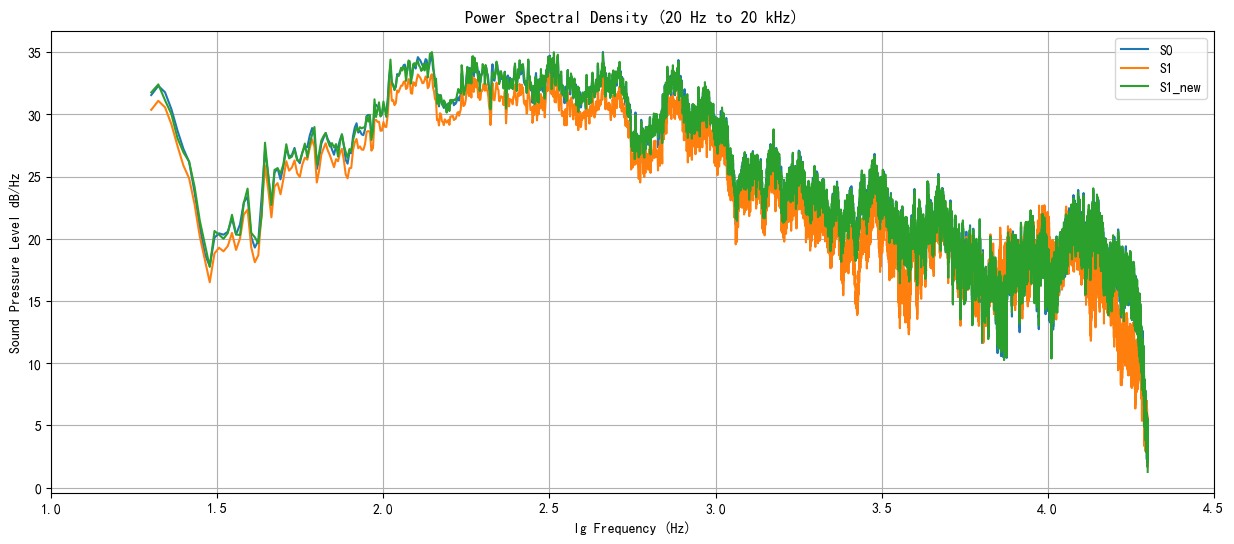

In [124]:
plt.figure(figsize=(15, 6))
plt.plot(np.log10(f_period1), 10 * np.log10(Pxx1_period1), label = 'S0')
plt.plot(np.log10(f_period1), 10 * np.log10(Pxx2_period1), label = 'S1')
plt.plot(np.log10(f_period1), 10 * np.log10(Pxx2_new_period1), label = 'S1_new')
plt.title('Power Spectral Density (20 Hz to 20 kHz)')
plt.xlabel('lg Frequency (Hz)')
plt.ylabel('Sound Pressure Level dB/Hz')
plt.xlim(1, 4.5)
plt.grid(True)
plt.legend()
plt.show()

In [125]:
# 计算误差

# 全音频段
S0_mag = S0_period1
S1_mag = S1_period1
S1_filterd_mag = S1_new_period1

error_before = np.mean(np.abs(S0_mag - S1_mag))
error_after = np.mean(np.abs(S0_mag - S1_filterd_mag))

# 打印误差
print("全音频段补偿前误差:", error_before, 'dB')
print("全音频段补偿后误差:", error_after, 'dB')

# 语言敏感频段

S0_mag = S0_period2
S1_mag = S1_period2
S1_filterd_mag = S1_new_period2

error_before = np.mean(np.abs(S0_mag - S1_mag))
error_after = np.mean(np.abs(S0_mag - S1_filterd_mag))

print("语言敏感频段补偿前误差 (200Hz - 2000Hz):", error_before, 'dB')
print("语言敏感频段补偿后误差 (200Hz - 2000Hz):", error_after, 'dB')

# 找到 1 kHz 对应的频率索引
target_freq = 1000  # 1 kHz
target_index = np.argmin(np.abs(frequencies - target_freq))

# 计算 1 kHz 处的幅度和相位误差
error_before_1k = S0_log[target_index] - S2_log[target_index]
error_after_1k = S0_log[target_index] - S2_filterd_log[target_index]

# 打印误差
print("1kHz 处补偿前误差:", error_before_1k, 'dB')
print("1kHz 处补偿后误差:", error_after_1k, 'dB')

全音频段补偿前误差: 2.253842955428575 dB
全音频段补偿后误差: 0.29918317698437646 dB
语言敏感频段补偿前误差 (200Hz - 2000Hz): 1.744243668989935 dB
语言敏感频段补偿后误差 (200Hz - 2000Hz): 0.26084518843730004 dB
1kHz 处补偿前误差: 1.7566934869426412 dB
1kHz 处补偿后误差: 0.09602297121768899 dB


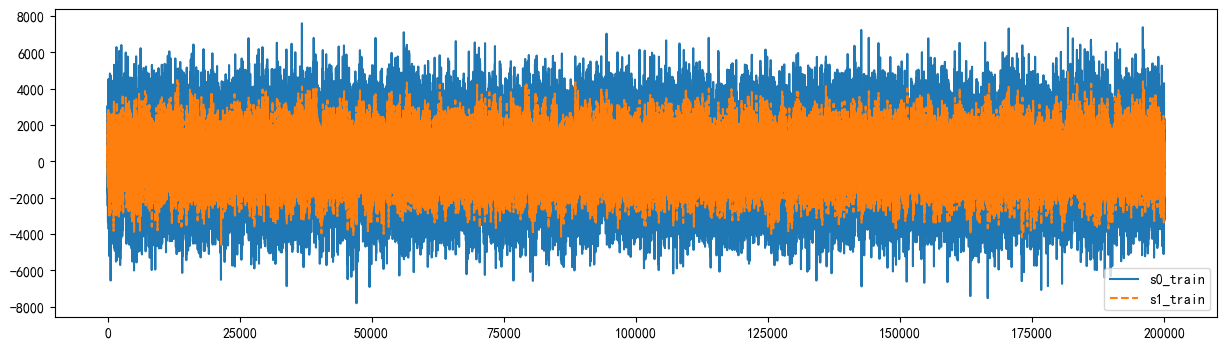

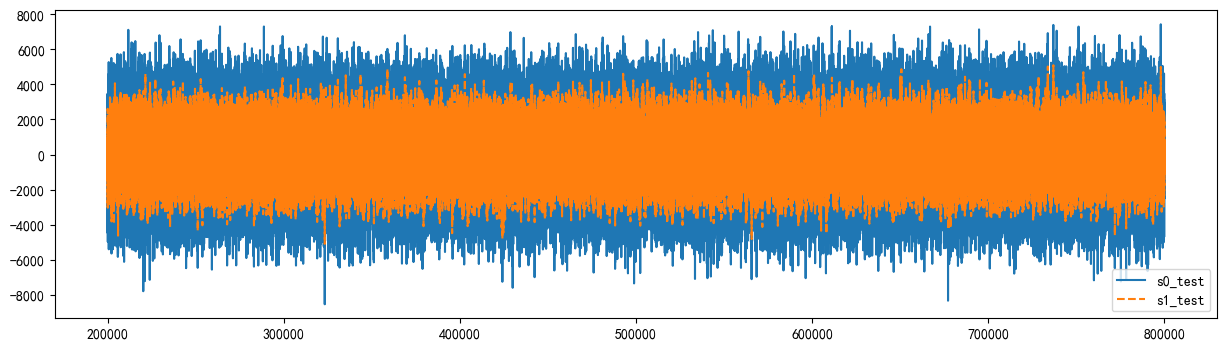

In [126]:
N0_train = 5 * fs
N1_train = N0_train
s0_train = s0[:N0_train]
s0_test = s0[N0_train:]
s1_train = s1[:N1_train]
s1_test = s1[N1_train:]
t0_train = t0[:N0_train]
t0_test = t0[N0_train:]
t1_train = t1[:N1_train]
t1_test = t1[N1_train:]

plotTwoSignal(t0_train, s0_train, s1_train, 's0_train', 's1_train')
plotTwoSignal(t0_test, s0_test, s1_test, 's0_test', 's1_test')

In [127]:
# 使用Welch方法计算功率谱密度（PSD）
f1, Pxx1 = welch(s0_train, fs, window='blackman', nperseg=fs, noverlap=fs // 2, nfft=fs, 
                   detrend='constant', return_onesided=True, scaling='density', axis=-1, 
                   average='mean')
f2, Pxx2 = welch(s1_train, fs, window='blackman', nperseg=fs, noverlap=fs // 2, nfft=fs, 
                   detrend='constant', return_onesided=True, scaling='density', axis=-1, 
                   average='mean')
f_train = f1

In [128]:
# 筛选频率范围20Hz到20kHz
freq_range1 = (f_train >= 20) & (f_train <= 20000)
freq_range2 = (f_train >= 200) & (f_train <= 2000)
f_train_period1 = f_train[freq_range1]
f_train_period2 = f_train[freq_range2]
Pxx1_period1 = Pxx1[freq_range1]
Pxx2_period1 = Pxx2[freq_range1]
Pxx1_period2 = Pxx1[freq_range2]
Pxx2_period2 = Pxx2[freq_range2]

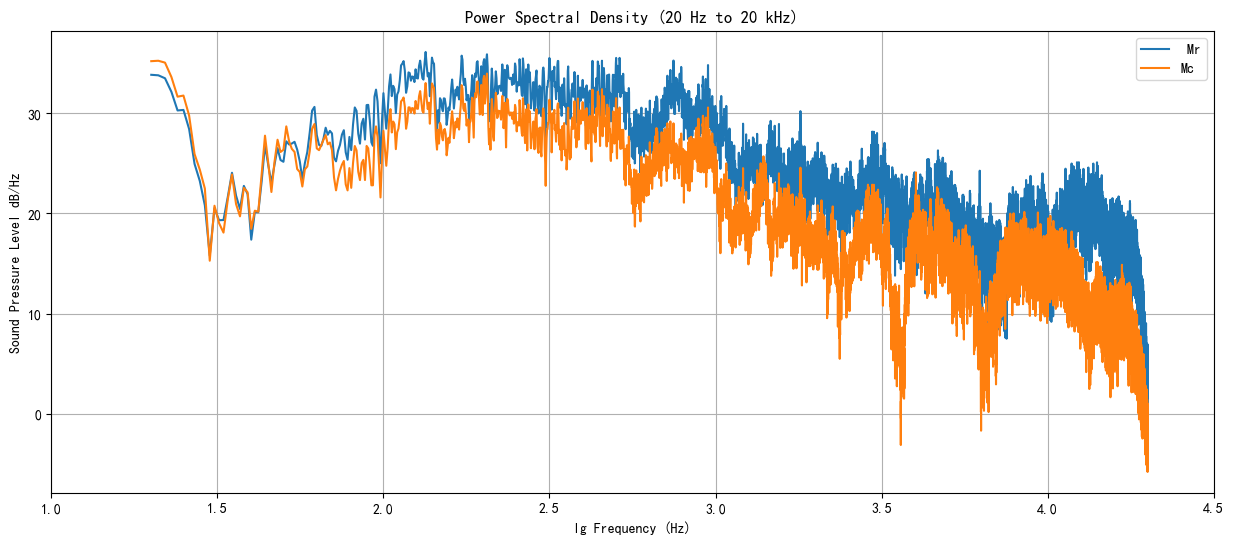

In [129]:
# 绘制功率谱密度图
plt.figure(figsize=(15, 6))
plt.plot(np.log10(f_train_period1), 10 * np.log10(Pxx1_period1), label = ' Mr')
plt.plot(np.log10(f_train_period1), 10 * np.log10(Pxx2_period1), label = 'Mc')
plt.title('Power Spectral Density (20 Hz to 20 kHz)')
plt.xlabel('lg Frequency (Hz)')
plt.ylabel('Sound Pressure Level dB/Hz')
plt.xlim(1, 4.5)
plt.grid(True)
plt.legend()
plt.show()

In [130]:
deltaP_period1 = Pxx1_period1 - Pxx2_period1
deltaP_period2 = Pxx1_period2 - Pxx2_period2

In [131]:
f1, Pxx1 = welch(s0_test, fs, window='blackman', nperseg=fs, noverlap=fs // 2, nfft=fs, 
                   detrend='constant', return_onesided=True, scaling='density', axis=-1, 
                   average='mean')
f2, Pxx2 = welch(s1_test, fs, window='blackman', nperseg=fs, noverlap=fs // 2, nfft=fs, 
                   detrend='constant', return_onesided=True, scaling='density', axis=-1, 
                   average='mean')
f_test = f1

In [132]:
S0_log = 10 * np.log10(Pxx1)
S1_log = 10 * np.log10(Pxx2)

In [133]:
# 筛选频率范围20Hz到20kHz
freq_range1 = (f_test >= 20) & (f_test <= 20000)
freq_range2 = (f_test >= 200) & (f_test <= 2000)
f_test_period1 = f_test[freq_range1]
f_test_period2 = f_test[freq_range2]
Pxx1_period1 = Pxx1[freq_range1]
Pxx2_period1 = Pxx2[freq_range1]
Pxx1_period2 = Pxx1[freq_range2]
Pxx2_period2 = Pxx2[freq_range2]

In [134]:
Pxx2_new_period1 = Pxx2_period1 + deltaP_period1
Pxx2_new_period2 = Pxx2_period2 + deltaP_period2

In [135]:
Pxx2_new_period1 = np.maximum(Pxx2_new_period1, 1)
Pxx2_new_period2 = np.maximum(Pxx2_new_period2, 1)

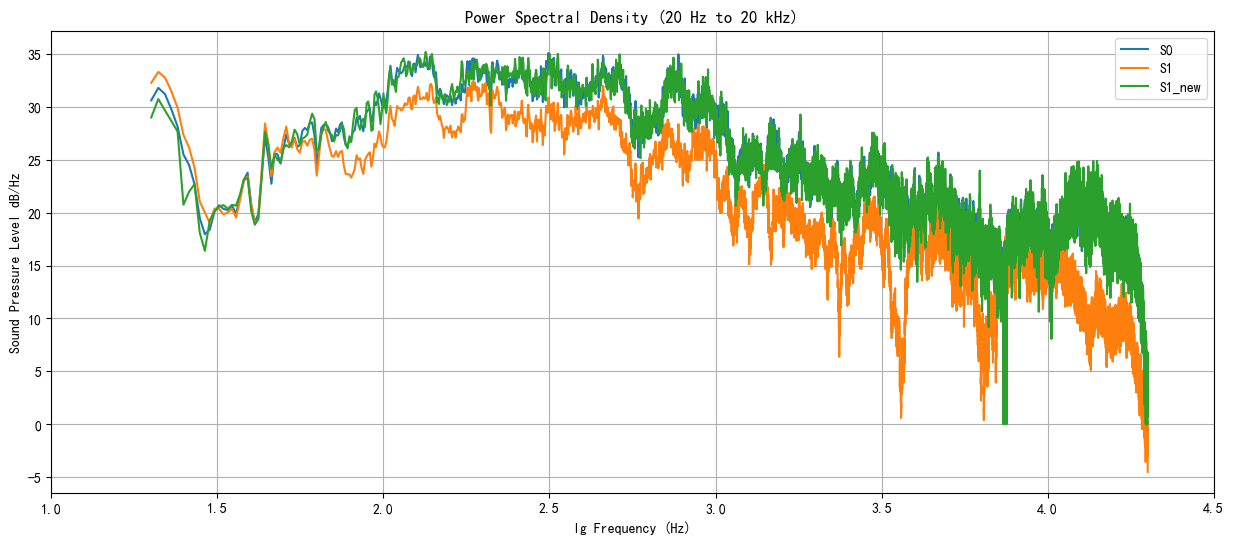

In [136]:
plt.figure(figsize=(15, 6))
plt.plot(np.log10(f_test_period1), 10 * np.log10(Pxx1_period1), label = 'S0')
plt.plot(np.log10(f_test_period1), 10 * np.log10(Pxx2_period1), label = 'S1')
plt.plot(np.log10(f_test_period1), 10 * np.log10(Pxx2_new_period1), label = 'S1_new')
plt.title('Power Spectral Density (20 Hz to 20 kHz)')
plt.xlabel('lg Frequency (Hz)')
plt.ylabel('Sound Pressure Level dB/Hz')
plt.xlim(1, 4.5)
plt.grid(True)
plt.legend()
plt.show()

In [137]:
S1_new_period1 = 10 * np.log10(Pxx2_new_period1)
S1_new_period2 = 10 * np.log10(Pxx2_new_period2)
S0_period1 = 10 * np.log10(Pxx1_period1)
S0_period2 = 10 * np.log10(Pxx1_period2)
S1_period1 = 10 * np.log10(Pxx2_period1)
S1_period2 = 10 * np.log10(Pxx2_period2)

In [138]:
# 计算误差

# 全音频段
S0_mag = S0_period1
S1_mag = S1_period1
S1_filterd_mag = S1_new_period1

error_before = np.mean(np.abs(S0_mag - S1_mag))
error_after = np.mean(np.abs(S0_mag - S1_filterd_mag))

# 打印误差
print("全音频段补偿前误差:", error_before, 'dB')
print("全音频段补偿后误差:", error_after, 'dB')

# 语言敏感频段

S0_mag = S0_period2
S1_mag = S1_period2
S1_filterd_mag = S1_new_period2

error_before = np.mean(np.abs(S0_mag - S1_mag))
error_after = np.mean(np.abs(S0_mag - S1_filterd_mag))

print("语言敏感频段补偿前误差 (200Hz - 2000Hz):", error_before, 'dB')
print("语言敏感频段补偿后误差 (200Hz - 2000Hz):", error_after, 'dB')

# 找到 1 kHz 对应的频率索引
target_freq = 1000  # 1 kHz
target_index = np.argmin(np.abs(frequencies - target_freq))

# 计算 1 kHz 处的幅度和相位误差
error_before_1k = S0_log[target_index] - S1_log[target_index]
error_after_1k = S0_log[target_index] - S1_new_period1[target_index]

# 打印误差
print("1kHz 处补偿前误差:", error_before_1k, 'dB')
print("1kHz 处补偿后误差:", error_after_1k, 'dB')

全音频段补偿前误差: 6.021129159942316 dB
全音频段补偿后误差: 0.9459967137224337 dB
语言敏感频段补偿前误差 (200Hz - 2000Hz): 4.6924822649441635 dB
语言敏感频段补偿后误差 (200Hz - 2000Hz): 0.8387178113348556 dB
1kHz 处补偿前误差: 4.119028887904804 dB
1kHz 处补偿后误差: -0.7924896155153895 dB


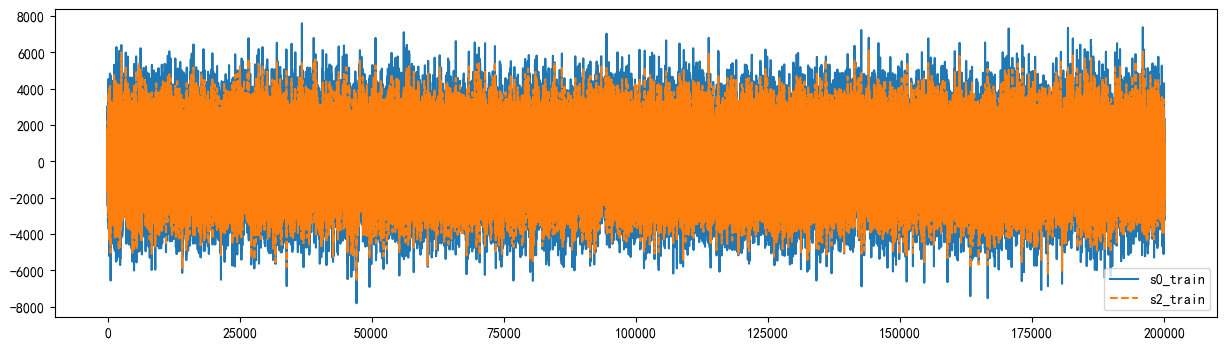

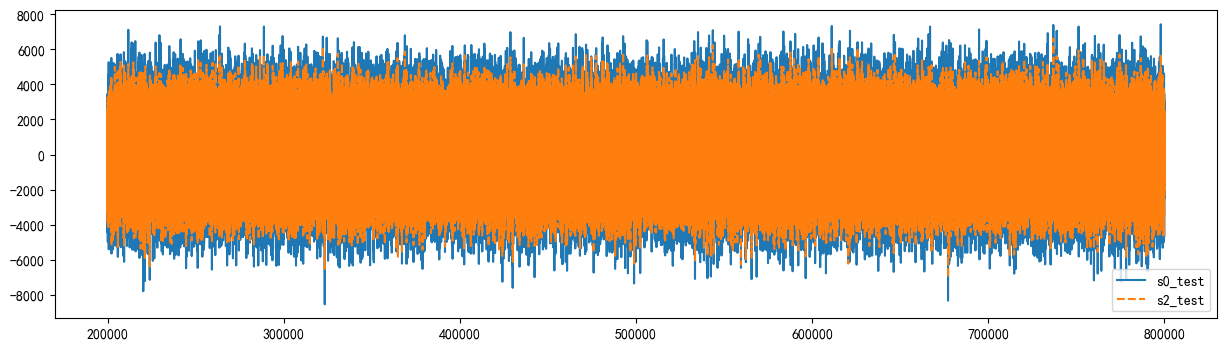

In [139]:
# 泛化
N0_train = 5 * fs
N1_train = N0_train
s0_train = s0[:N0_train]
s0_test = s0[N0_train:]
s2_train = s2[:N1_train]
s2_test = s2[N1_train:]
t0_train = t0[:N0_train]
t0_test = t0[N0_train:]
t2_train = t1[:N1_train]
t2_test = t1[N1_train:]

plotTwoSignal(t0_train, s0_train, s2_train, 's0_train', 's2_train')
plotTwoSignal(t0_test, s0_test, s2_test, 's0_test', 's2_test')

In [140]:
# 泛化
f1, Pxx1 = welch(s0_train, fs, window='blackman', nperseg=fs, noverlap=fs // 2, nfft=fs, 
                   detrend='constant', return_onesided=True, scaling='density', axis=-1, 
                   average='mean')
f2, Pxx2 = welch(s2_train, fs, window='blackman', nperseg=fs, noverlap=fs // 2, nfft=fs, 
                   detrend='constant', return_onesided=True, scaling='density', axis=-1, 
                   average='mean')
f_train = f1

In [141]:
S0_log = 10 * np.log10(Pxx1)
S1_log = 10 * np.log10(Pxx2)

In [142]:
# 筛选频率范围20Hz到20kHz
freq_range1 = (f_train >= 20) & (f_train <= 20000)
freq_range2 = (f_train >= 200) & (f_train <= 2000)
f_train_period1 = f_train[freq_range1]
f_train_period2 = f_train[freq_range2]
Pxx1_period1 = Pxx1[freq_range1]
Pxx2_period1 = Pxx2[freq_range1]
Pxx1_period2 = Pxx1[freq_range2]
Pxx2_period2 = Pxx2[freq_range2]

In [143]:
deltaP_period1 = Pxx1_period1 - Pxx2_period1
deltaP_period2 = Pxx1_period2 - Pxx2_period2

In [144]:
f1, Pxx1 = welch(s0_test, fs, window='blackman', nperseg=fs, noverlap=fs // 2, nfft=fs, 
                   detrend='constant', return_onesided=True, scaling='density', axis=-1, 
                   average='mean')
f2, Pxx2 = welch(s2_test, fs, window='blackman', nperseg=fs, noverlap=fs // 2, nfft=fs, 
                   detrend='constant', return_onesided=True, scaling='density', axis=-1, 
                   average='mean')
f_test = f1

In [145]:
# 筛选频率范围20Hz到20kHz
freq_range1 = (f_test >= 20) & (f_test <= 20000)
freq_range2 = (f_test >= 200) & (f_test <= 2000)
f_test_period1 = f_test[freq_range1]
f_test_period2 = f_test[freq_range2]
Pxx1_period1 = Pxx1[freq_range1]
Pxx2_period1 = Pxx2[freq_range1]
Pxx1_period2 = Pxx1[freq_range2]
Pxx2_period2 = Pxx2[freq_range2]

In [146]:
Pxx2_new_period1 = Pxx2_period1 + deltaP_period1
Pxx2_new_period2 = Pxx2_period2 + deltaP_period2

In [147]:
Pxx2_new_period1 = np.maximum(Pxx2_new_period1, 1)
Pxx2_new_period2 = np.maximum(Pxx2_new_period2, 1)

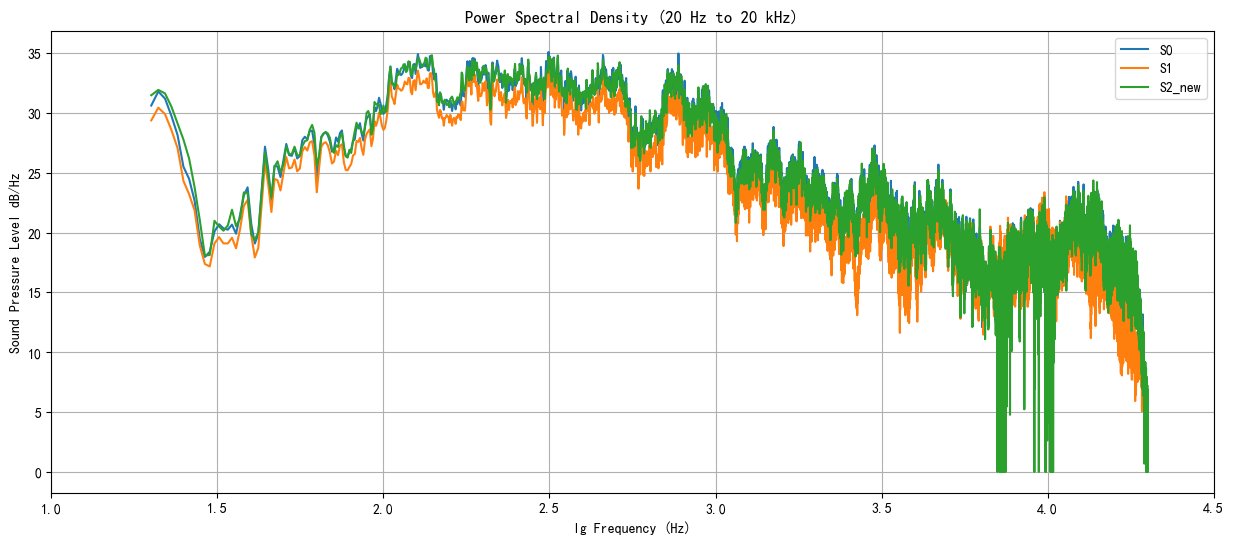

In [148]:
plt.figure(figsize=(15, 6))
plt.plot(np.log10(f_test_period1), 10 * np.log10(Pxx1_period1), label = 'S0')
plt.plot(np.log10(f_test_period1), 10 * np.log10(Pxx2_period1), label = 'S1')
plt.plot(np.log10(f_test_period1), 10 * np.log10(Pxx2_new_period1), label = 'S2_new')
plt.title('Power Spectral Density (20 Hz to 20 kHz)')
plt.xlabel('lg Frequency (Hz)')
plt.ylabel('Sound Pressure Level dB/Hz')
plt.xlim(1, 4.5)
plt.grid(True)
plt.legend()
plt.show()

In [149]:
S1_new_period1 = 10 * np.log10(Pxx2_new_period1)
S1_new_period2 = 10 * np.log10(Pxx2_new_period2)
S0_period1 = 10 * np.log10(Pxx1_period1)
S0_period2 = 10 * np.log10(Pxx1_period2)
S1_period1 = 10 * np.log10(Pxx2_period1)
S1_period2 = 10 * np.log10(Pxx2_period2)

In [150]:
# 计算误差

# 全音频段
S0_mag = S0_period1
S1_mag = S1_period1
S1_filterd_mag = S1_new_period1

error_before = np.mean(np.abs(S0_mag - S1_mag))
error_after = np.mean(np.abs(S0_mag - S1_filterd_mag))

# 打印误差
print("全音频段补偿前误差:", error_before, 'dB')
print("全音频段补偿后误差:", error_after, 'dB')

# 语言敏感频段

S0_mag = S0_period2
S1_mag = S1_period2
S1_filterd_mag = S1_new_period2

error_before = np.mean(np.abs(S0_mag - S1_mag))
error_after = np.mean(np.abs(S0_mag - S1_filterd_mag))

print("语言敏感频段补偿前误差 (200Hz - 2000Hz):", error_before, 'dB')
print("语言敏感频段补偿后误差 (200Hz - 2000Hz):", error_after, 'dB')

# 找到 1 kHz 对应的频率索引
target_freq = 1000  # 1 kHz
target_index = np.argmin(np.abs(frequencies - target_freq))

# 计算 1 kHz 处的幅度和相位误差
error_before_1k = S0_log[target_index] - S1_log[target_index]
error_after_1k = S0_log[target_index] - S1_new_period1[target_index]

# 打印误差
print("1kHz 处补偿前误差:", error_before_1k, 'dB')
print("1kHz 处补偿后误差:", error_after_1k, 'dB')

全音频段补偿前误差: 2.254472447367964 dB
全音频段补偿后误差: 0.6060973198831127 dB
语言敏感频段补偿前误差 (200Hz - 2000Hz): 1.7418576392363598 dB
语言敏感频段补偿后误差 (200Hz - 2000Hz): 0.4344517087995374 dB
1kHz 处补偿前误差: 1.6991107002141064 dB
1kHz 处补偿后误差: -0.4243066445947328 dB
